# CS 378 Homework 3: The Science of Fairness (100 pts)

## Deadline: 11:59 pm, October 13, 2022

This assignment has three parts. In the first part, you will perform an analysis of fairness on the COMPAS dataset that you previously encountered in Assignment 1. The second and third parts consist of theoretical questions about fairness criteria and causality. 


## Part 1: Further analysis of the COMPAS dataset

### Prelude

Here is the code for loading and cleaning up the dataset.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Data = pd.read_csv("german_credit_data.csv")
#print (Data.columns)

Data['Saving accounts'] = Data['Saving accounts'].map({"little":0,"moderate":1,"quite rich":2 ,"rich":3 });
Data['Saving accounts'] = Data['Saving accounts'].fillna(Data['Saving accounts'].dropna().mean())

Data['Checking account'] = Data['Checking account'].map({"little":0,"moderate":1,"rich":2 });
Data['Checking account'] = Data['Checking account'].fillna(Data['Checking account'].dropna().mean())

Data['Sex'] = Data['Sex'].map({"male":0,"female":1}).astype(float)

Data['Housing'] = Data['Housing'].map({"own":0,"free":1,"rent":2}).astype(float)

Data['Purpose'] = Data['Purpose'].map({'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}).astype(float)

Data['Risk'] = Data['Risk'].map({"good":0,"bad":1}).astype(float)
Data = Data.drop(columns=['Unnamed: 0'])
#print (Data.columns)
#Data.head(10)
#Data.drop('Unnamed: 0')
Data.head(10)

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


And here is the code for performing a train-test split, training a logistic regression model, and computing the test accuracy.

In [2]:
X = df_final.drop(columns=['is_recid', 'is_violent_recid', "race"])
Y = df_final['is_recid']

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=137)

In [5]:
# YOUR CODE HERE

import torch
from torch.autograd import Variable


class DNN_model(torch.nn.Module):
 def __init__(self,no_input_features):
    super(DNN_model,self).__init__()
    self.layer1 = torch.nn.Linear(no_input_features,20)
    self.layer2 = torch.nn.Linear(20,20)
    self.layer3 = torch.nn.Linear(20,20)
    self.layer4 = torch.nn.Linear(20,20)
    self.layer5 = torch.nn.Linear(20,1)
    
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
        
    self.seq = torch.nn.Sequential(
        self.layer1,
        self.relu,
        self.layer2,
        self.relu,
        self.layer3,
        self.relu,
        self.layer4,
        self.relu,
        self.layer5,
        self.sigmoid
    )

 def forward(self,x):
    # YOUR ANSWER HERE
    return self.seq(x)

print(train_x.shape)

dnnmodel = DNN_model(10)
dnnepochs = 15
dnnlr = 5e-4
dnnoptimizer = torch.optim.Adam(dnnmodel.parameters(), lr=dnnlr, weight_decay=1e-5)
for epoch in range(dnnepochs):
    #print ("hey")
    print ("epoch", epoch)
    train(epoch, dnnmodel, trainDataLoader, dnnoptimizer, criterion, testDataLoader)

torch.save(dnnmodel, "dnnmodel.pt")



'''lr_prediction = logistic_regression.predict_proba(test_x)

#print (lr_prediction)

lr_prediction_df = pd.DataFrame(lr_prediction)
lr_prediction_df = lr_prediction_df.applymap(lambda x: 1 if x > 0.7 else 0).iloc[:, 1:]

thresholdAccuracy = metrics.accuracy_score(test_y, lr_prediction_df)
print ("Percent Accuracy for LR classifier w threshold 0.7", thresholdAccuracy * 100)'''

(4937, 12)
epoch 0


NameError: name 'train' is not defined

#### Q4: Show the ROC curves for the black and white subgroups, and plot the points corresponding to the different strategies clearly identified. The resulting curve should look like the ROC curve in the FICO score case study that was discussed in class.  (5 points)

In [ ]:
import matplotlib.pyplot as plt


from matplotlib.pyplot import figure




fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

#figure(figsize=(8, 6), dpi=200)



fpr_b, tpr_b, thresholds_b = metrics.roc_curve(test_y_black, lr_prediction_black)
auc = metrics.roc_auc_score(test_y_black, lr_prediction_black)
plt.plot(fpr_b,tpr_b,label="ROC Curve - Black, auc="+str(auc))

fpr_w, tpr_w, thresholds_w = metrics.roc_curve(test_y_white, lr_prediction_white)
auc = metrics.roc_auc_score(test_y_white, lr_prediction_white)
plt.plot(fpr_w,tpr_w,label="ROC Curve - White, auc="+str(auc))

lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minBlackThreshold else 0)
lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minWhiteThreshold else 0)


ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='black', marker='^', s=100, label='Max Profit Black')
ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='green', marker='^', s= 100, label="Max Profit White")

plt.legend(loc=0, bbox_to_anchor=(1,1))

#### Q5: (i) Do a calibration plot that plots the fraction of defendants recidividating within two years as a function of the predicted probability of recidivism, for black defendants and white defendants. (ii) Comment (in a couple of sentences) if you believe that the score satisfies sufficiency across racial groups.      (5 points)

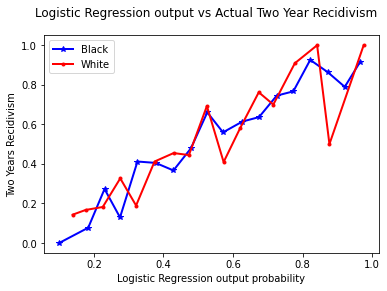

In [89]:
# YOUR CODE HERE 
from sklearn.calibration import calibration_curve
y_b, x_b = calibration_curve(
    test_y_black, 
    lr_prediction_black, 
    n_bins=20)

y_w, x_w = calibration_curve(
    test_y_white, 
    lr_prediction_white, 
    n_bins=20)


fig, ax = plt.subplots()

plt.plot(x_b, y_b, color='blue', 
         marker='*', 
         linewidth = 2, 
         label='Black')

plt.plot(x_w, y_w, color='red', 
         marker='.', 
         linewidth = 2, 
         label='White')

# # reference line, legends, and axis labels
ax.set_xlabel('Logistic Regression output probability')
ax.set_ylabel('Two Years Recidivism')
fig.suptitle('Logistic Regression output vs Actual Two Year Recidivism')
plt.legend()
plt.show()



Being sufficient means Y _|_ A | R.  As in general, both line graphs closely follows each other, I think that sufficiency does indeed hold true here.

#### Q6: (i) Plot the distributions of scores received by the positive class (recidivists) and the distribution of scores received by the negative class (non-recidivists) for black and white defendants. (ii) Based on these plots, comment (in a couple of sentences) if this score satisfies separation.  (5 points)

/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_5678/2890315645.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lr_prediction_white_nonrecid,
/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_5678/2890315645.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lr_predict

'\n\nindex_val_one = all_of_w[\'is_recid\'] == 1\nall_of_w_pos = all_of_w.loc[index_val_one]\nall_of_w_pos = all_of_w_pos.drop(columns = ["is_recid"])\nprob_w_g_pos = logistic_regression.predict_proba(all_of_w_pos)\npred_w_g_pos = prob_w_g_pos[:,1]\n\nindex_val_two = all_of_w[\'is_recid\'] == 0\nall_of_w_neg = all_of_w.loc[index_val_two]\nall_of_w_neg = all_of_w_neg.drop(columns = ["is_recid"])\nprob_w_g_neg = logistic_regression.predict_proba(all_of_w_neg)\npred_w_g_neg = prob_w_g_neg[:,1]'

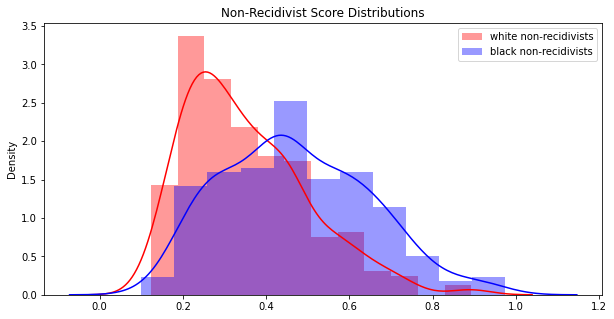

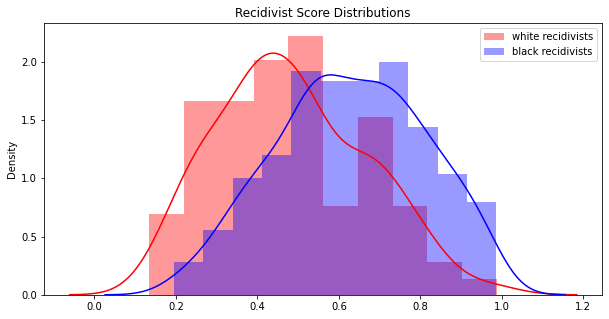

In [100]:
# YOUR CODE HERE

#print (test_y_white.head())



#all_of_w = test_x_w.join(test_y_w)

test_x_white_recid = test_x_white[test_y_white == 1]
test_y_white_recid = test_y_white[test_y_white == 1]
test_x_white_nonrecid = test_x_white[test_y_white == 0]
test_y_white_nonrecid = test_y_white[test_y_white == 0]

#print (test_x_white_nonrecid.head())

lr_prediction_white_recid = logistic_regression.predict_proba(test_x_white_recid)[:, 1:]
lr_prediction_white_nonrecid = logistic_regression.predict_proba(test_x_white_nonrecid)[:, 1:]


test_x_black_recid = test_x_black[test_y_black == 1]
test_y_black_recid = test_y_black[test_y_black == 1]
test_x_black_nonrecid = test_x_black[test_y_black == 0]
test_y_black_nonrecid = test_y_black[test_y_black == 0]

#print (test_x_black_nonrecid.head())

lr_prediction_black_recid = logistic_regression.predict_proba(test_x_black_recid)[:, 1:]
lr_prediction_black_nonrecid = logistic_regression.predict_proba(test_x_black_nonrecid)[:, 1:]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(lr_prediction_white_nonrecid, 
             color="red", 
             label="white non-recidivists").set(title = "Non-Recidivist Score Distributions")
sns.distplot(lr_prediction_black_nonrecid, 
             color="blue", 
             label="black non-recidivists").set(title = "Non-Recidivist Score Distributions")
plt.legend()

import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(lr_prediction_white_recid, 
             color="red", 
             label="white recidivists").set(title = "Recidivist Score Distributions")
sns.distplot(lr_prediction_black_recid, 
             color="blue", 
             label="black recidivists").set(title = "Recidivist Score Distributions")
plt.legend()






'''

index_val_one = all_of_w['is_recid'] == 1
all_of_w_pos = all_of_w.loc[index_val_one]
all_of_w_pos = all_of_w_pos.drop(columns = ["is_recid"])
prob_w_g_pos = logistic_regression.predict_proba(all_of_w_pos)
pred_w_g_pos = prob_w_g_pos[:,1]

index_val_two = all_of_w['is_recid'] == 0
all_of_w_neg = all_of_w.loc[index_val_two]
all_of_w_neg = all_of_w_neg.drop(columns = ["is_recid"])
prob_w_g_neg = logistic_regression.predict_proba(all_of_w_neg)
pred_w_g_neg = prob_w_g_neg[:,1]'''


Separation means that R _|_ A | Y.  So given the true label of recidivism, the logistic regression output must be independent of the race sensitive variable A.  This does NOT satisfy separation, because for both labels (non-recidivists and recidivists), we can see that the model outputted significantly lower scores for white people.